In [1]:
import math
import numpy as np
from itertools import product
import random

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
def sample_colors_from_span(splits):
    span_lenght = 256
    pixel_values = np.arange(span_lenght)
    idx = np.round(np.linspace(0, len(pixel_values) - 1, splits)).astype(int)
    sampled_values = pixel_values[idx].tolist()
    return np.array(list(product(sampled_values, repeat=3)))

In [4]:
splits = 6

colors = sample_colors_from_span(splits=splits)

In [5]:
systematic_colors = sample_colors_from_span(splits=2)

In [6]:
all([(a == colors).all(-1).any() for a in systematic_colors])

True

In [7]:
# colors0 = list(product(list(np.arange(0, 255+1, division+1)), repeat=3))
# colors0 = np.array(colors0).round().astype(int)
# colors1 = np.array(list(product(np.array_split(np.arange(256), splits), repeat=3)))

In [8]:
def display_colors(color_array, patches_per_row=10, patch_size=1):
    """
    Display a list of colors using matplotlib in multiple rows and larger patches.
    
    Parameters:
    color_array (numpy.ndarray): A 2D NumPy array with shape (n, 3), where each row represents an RGB color.
    patches_per_row (int): The number of color patches per row.
    patch_size (int or float): The size of each color patch.
    """
    num_colors = color_array.shape[0]
    num_rows = math.ceil(num_colors / patches_per_row)
    
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(patches_per_row * patch_size, num_rows * patch_size))
    
    # Create a patch for each color
    for idx, color in enumerate(color_array):
        # Normalize the RGB values to the range [0, 1]
        normalized_color = color / 255.0
        row = idx // patches_per_row
        col = idx % patches_per_row
        ax.add_patch(
            plt.Rectangle(
                (col * patch_size, row * patch_size), patch_size, patch_size, color=normalized_color))
    
    # Set the limits and hide the axes
    ax.set_xlim(0, patches_per_row * patch_size)
    ax.set_ylim(0, num_rows * patch_size)
    ax.invert_yaxis()
    ax.axis('off')
    
    plt.show()

In [9]:
colors.shape

(216, 3)

In [10]:
display_colors(colors, patches_per_row=18, patch_size=8)

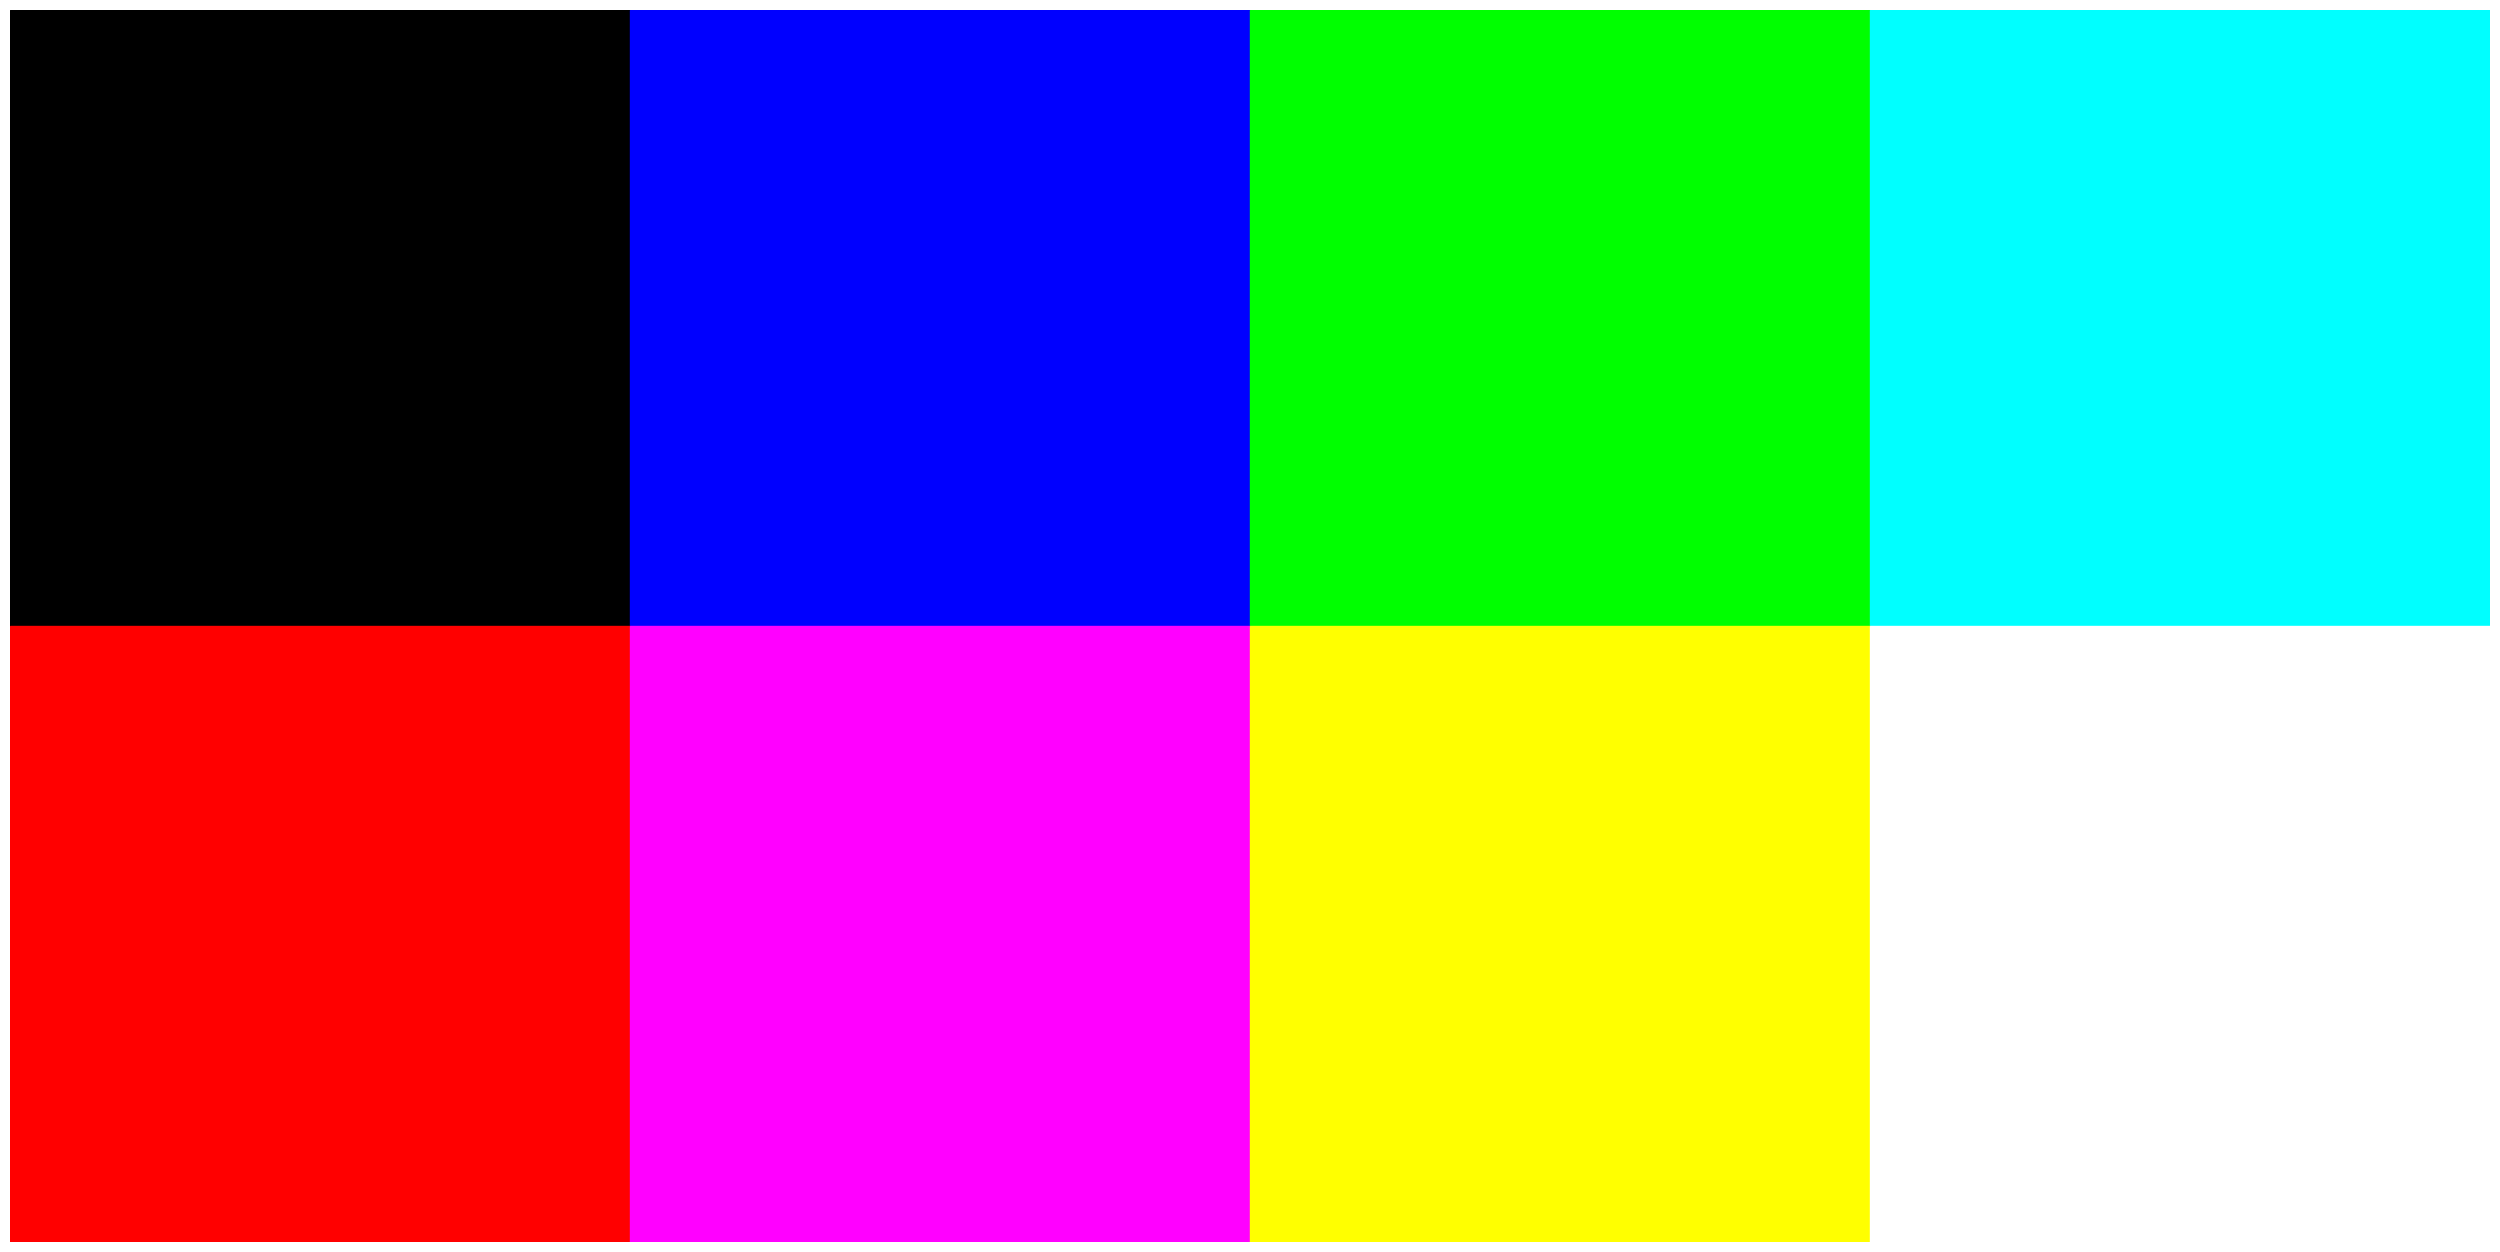

In [11]:
display_colors(systematic_colors, patches_per_row=4, patch_size=8)

In [12]:
def rgb_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(*color)

In [13]:
named_colors = {rgb_to_hex(c): c for c in colors.tolist()}
named_systematic_colors = {rgb_to_hex(c): c for c in systematic_colors.tolist()}

In [14]:
properties = {
  "shapes": {
    "cube": "SmoothCube_v2",
    "sphere": "Sphere",
    "cylinder": "SmoothCylinder"
  },
  "colors": named_colors,
  "materials": {
    "rubber": "Rubber",
    "metal": "MyMetal"
  },
  "sizes": {
    "large": 0.7,
    "small": 0.35
  }
}

In [15]:
actual_num_colors = len(named_colors)
assert splits**3 == actual_num_colors

actual_num_colors

216

In [16]:
import json
base_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2/'
with open(base_dir + f'properties-{actual_num_colors}c.json', 'w') as fp:
    json.dump(properties, fp, indent=2)

In [17]:
all_color_names = list(named_colors.keys())
systematic_color_names = list(named_systematic_colors.keys())

In [18]:
k = 8
sr = k // 2
s = len(systematic_color_names) // 2

if actual_num_colors != 8:
    rand_systematic_color_names = random.sample(list(set(all_color_names) - set(systematic_color_names)), k=k)
else:
    rand_systematic_color_names = systematic_color_names

In [19]:
random.shuffle(rand_systematic_color_names)
random.shuffle(systematic_color_names)

In [20]:
b_cube_colors = rand_systematic_color_names[:sr]
b_cylinder_colors = rand_systematic_color_names[sr:]
c_cube_colors = systematic_color_names[:s]
c_cylinder_colors = systematic_color_names[s:]

train_cube_colors = list(set(all_color_names) - set(b_cube_colors) - set(c_cube_colors))
train_cylinder_colors = list(set(all_color_names) - set(b_cylinder_colors) - set(c_cylinder_colors))

new_cogen_a = {
    "cube": train_cube_colors,
    "cylinder": train_cylinder_colors,
    "sphere": all_color_names,
}
new_cogen_b = {
    "cube": b_cube_colors,
    "cylinder": b_cylinder_colors,
    "sphere": all_color_names,
}
new_cogen_c = {
    "cube": c_cube_colors,
    "cylinder": c_cylinder_colors,
    "sphere": all_color_names,
}

In [21]:
assert not set(new_cogen_b["cube"]).issubset(set(new_cogen_a["cube"]))
assert not set(new_cogen_c["cube"]).issubset(set(new_cogen_a["cube"]))
assert (
    set(new_cogen_c["cube"]) | 
    set(new_cogen_b["cube"]) | 
    set(new_cogen_a["cube"]) 
    == set(new_cogen_a["sphere"]))

assert not set(new_cogen_b["cylinder"]).issubset(set(new_cogen_a["cylinder"]))
assert not set(new_cogen_c["cylinder"]).issubset(set(new_cogen_a["cylinder"]))
assert (
    set(new_cogen_c["cylinder"]) | 
    set(new_cogen_b["cylinder"]) | 
    set(new_cogen_a["cylinder"]) 
    == set(new_cogen_a["sphere"]))

assert set(new_cogen_b["sphere"]) == set(new_cogen_a["sphere"])
assert set(new_cogen_c["sphere"]) == set(new_cogen_a["sphere"])

In [22]:
print(len(new_cogen_a['cube']), len(new_cogen_b['cube']), len(new_cogen_c['cube']))
print(len(new_cogen_a['cylinder']), len(new_cogen_b['cylinder']), len(new_cogen_c['cylinder']))
print(len(new_cogen_a['sphere']), len(new_cogen_b['sphere']), len(new_cogen_c['sphere']))

208 4 4
208 4 4
216 216 216


In [23]:
with open(f'{base_dir}/CoGenT_A-{actual_num_colors}c.json', 'w') as fp:
    json.dump(new_cogen_a, fp, indent=2)

with open(f'{base_dir}/CoGenT_B-{actual_num_colors}c.json', 'w') as fp:
    json.dump(new_cogen_b, fp, indent=2)
    
if actual_num_colors == 8:
    with open(f'{base_dir}/CoGenT_C-{actual_num_colors}c.json', 'w') as fp:
        json.dump(new_cogen_c, fp, indent=2)

In [24]:
base_dir

'/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2/'